In [123]:
import tensorflow
import numpy
import matplotlib

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.6.0
1.21.4
3.4.3


In [124]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 1. 데이터 전처리

## 1-1) 데이터 정제 및 토큰화

In [125]:
import os

data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    #중복제거
    cleaned_corpus = set(zip(kor,eng))
    
    cleaned_kor, cleaned_eng = zip(*cleaned_corpus)
    cleaned_corpus = list(zip(cleaned_kor, cleaned_eng))
    
    cleaned_corpus = ["\t".join(pair) for pair in cleaned_corpus]
    
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [126]:
print(len(cleaned_corpus))

78968


## 1-2) 정제함수 정의

- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [127]:
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() #소문자 변환

    #문장부호 양옆에 공백을 추가
    regex = re.compile(r"([?.!,])")
    sentence = regex.sub(r" \1 ", sentence)
    #\1 : 일치하는 특수 문자(?, !, .)를 나타냄
    # r" \1 "는 일치하는 특수 문자 앞뒤에 공백을 추가

    regex = re.compile(r'[" "]+')
    sentence = regex.sub(" ", sentence) #불필요한 공백 제거

    regex = re.compile(r"[^a-zA-Z가-힣?.!,]+")
    sentence = regex.sub(" ", sentence)#불필요한 문자 제거

    return sentence

## 1-3) 토큰화

한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요.
 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다.
 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

In [128]:
import sentencepiece as spm

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    with open(f"{lang}.txt", "w", encoding="utf-8") as f:
        for sentence in corpus:
            f.write(sentence + "\n")  # 각 문장을 줄바꿈으로 구분하여 저장
        
    # SentencePiece 모델 학습
    spm.SentencePieceTrainer.train(
        f"--input={lang}.txt --model_prefix={lang} --vocab_size={vocab_size} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id}"
    )

    # SentencePieceProcessor 생성 및 반환
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{lang}.model")

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko.txt --model_prefix=ko --vocab_size=20000 --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko.txt
  input_format: 
  model_prefix: ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: <

True

In [129]:
import pandas as pd
import csv

vocab_list = pd.read_csv('ko.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.sample(10)

,0,1
11500,▁주장했었다,-11.5971
743,▁대해서,-8.7072
10404,투쟁,-11.4714
6523,ff,-10.8851
11960,▁불량,-11.6528
3168,▁동물원,-10.0703
8118,▁블룸버그,-11.1601
13777,▁prevent,-11.9072
7802,son,-11.0968
3956,▁비판했다,-10.3212


In [130]:
len(vocab_list)

20000

In [131]:
len(kor_corpus)

78968

In [132]:
kor_sentence = "안녕하세요, 저는 AI 개발자입니다."
eng_sentence = "Hello, I am an AI developer."

kor_tokens = ko_tokenizer.encode_as_pieces(kor_sentence)
eng_tokens = en_tokenizer.encode_as_pieces(eng_sentence)

print(kor_tokens)  # [' 안녕', '하세요', ',', ' 저는', ' AI', ' 개발자', '입니다', '.']
print(eng_tokens)  # [' ', 'Hello', ',', ' I', ' am', ' an', ' AI', ' developer', '.']

['▁안', '녕', '하', '세요', ',', '▁저', '는', '▁', 'AI', '▁개발', '자', '입니다', '.']
['<s>', '▁', 'H', 'ello', ',', '▁', 'I', '▁am', '▁an', '▁', 'AI', '▁developer', '.', '</s>']


## 1-4) 패팅 처리 및 텐서 변환

In [133]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해
import tensorflow as tf

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)


max_len = 50
sen_len = 50000
#20000 -> 50000 증강

#문장 길이 저장 
sentence_lengths_ko = []
sentence_lengths_en = []

for idx in tqdm(range(len(kor_corpus[:sen_len]))):
    #토큰화
    kor_tokens = ko_tokenizer.encode_as_pieces(kor_corpus[idx])
    eng_tokens = en_tokenizer.encode_as_pieces(eng_corpus[idx])
    
    #문장길이 저장
    sentence_lengths_ko.append(len(kor_tokens))
    sentence_lengths_en.append(len(eng_tokens))
    
    # 토큰의 길이가 50 이하인 문장만 남깁니다. 
    if len(kor_tokens) <= 50 and len(eng_tokens) <= 50:
        #숫자 인코딩 후 문자열에 추가
        src_corpus.append(ko_tokenizer.encode_as_ids(kor_corpus[idx]))
        tgt_corpus.append(en_tokenizer.encode_as_ids(eng_corpus[idx]))
        
        

# 패딩처리를 완료하여 학습용 데이터를 완성
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/50000 [00:00<?, ?it/s]

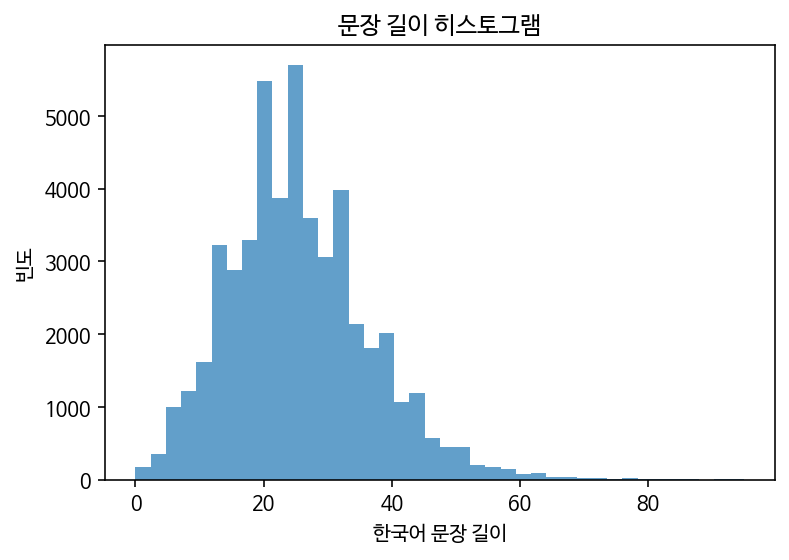

In [157]:
# 히스토그램
plt.hist(sentence_lengths_ko, bins=20, alpha=0.7)
plt.xlabel("한국어 문장 길이")
plt.ylabel("빈도")
plt.title("문장 길이 히스토그램")
plt.show()

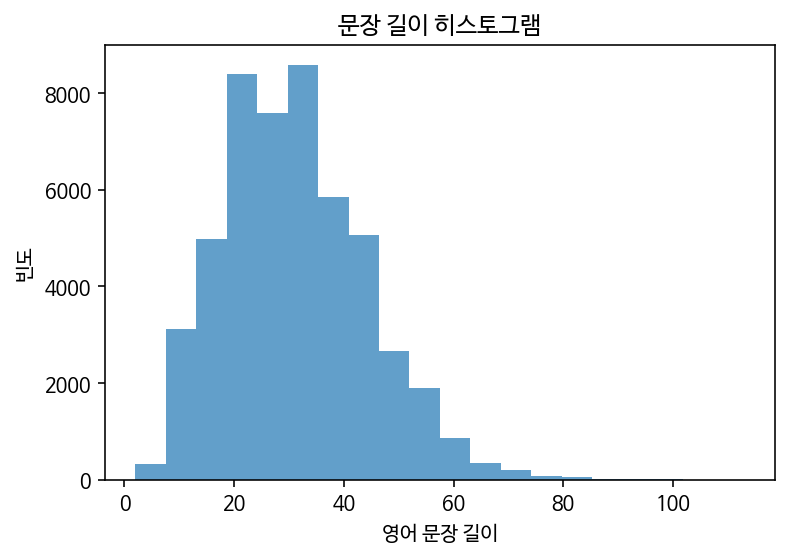

In [159]:
# 히스토그램
plt.hist(sentence_lengths_en, bins=20, alpha=0.7)
plt.xlabel("영어 문장 길이")
plt.ylabel("빈도")
plt.title("문장 길이 히스토그램")
plt.show()

# 2. 모델 설계

## 2-1) 모델 블럭 제작

### Positional Encoding

In [135]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

### Multi-Head Attention

In [136]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
            
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### FFN

In [137]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

## 2-2) 모듈 조립

### EncoderLayer

In [138]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

### DecoderLayer

In [139]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
 

### Encoder

In [140]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### Decoder

In [141]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer

In [142]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

### mask

In [143]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

# Step 3. 훈련하기

앞서 필요한 것들을 모두 정의했기 때문에 우리는 훈련만 하면 됩니다! 아래 과정을 차근차근 따라가며 모델을 훈련하고, 예문에 대한 멋진 번역을 제출하세요!


## 3-1) Transformer 선언

2 Layer를 가지는 Transformer를 선언하세요.
(하이퍼파라미터는 자유롭게 조절합니다.)

In [144]:
# 2 Layer Transformer 선언
transformer = Transformer(
    n_layers=2,              # 레이어 개수 (2개)
    d_model=512,             # 모델 차원
    n_heads=8,               # 헤드 개수
    d_ff=2048,               # 피드 포워드 네트워크 차원
    src_vocab_size=SRC_VOCAB_SIZE,  # 소스 어휘 크기
    tgt_vocab_size=TGT_VOCAB_SIZE,  # 타겟 어휘 크기
    pos_len=200,             # 포지셔널 인코딩 최대 길이
    dropout=0.2,             # 드롭아웃 확률
    shared=True              # 임베딩 공유 여부
)

## 3-2) learning_rate, optimizer, Loss정의

논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요.
 (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

### learning_rate

In [145]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)

### optimizer

In [146]:
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### Loss

Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [147]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## 3-3) Train_step


train_step 함수를 정의하세요.
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [148]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]  # 정답 데이터
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)  # 마스크 생성

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])  # 손실 계산

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다.
    gradients = tape.gradient(loss, model.trainable_variables)  # 기울기 계산
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # 기울기 적용

    return loss, enc_attns, dec_attns, dec_enc_attns

### 번역생성 함수

In [149]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [150]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [151]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

## 3-4) training

In [152]:
# 학습

from tqdm import tqdm_notebook 
import random
import matplotlib.pyplot as plt

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=False)

/tmp/ipykernel_39/3013602775.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/714 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a great time .
Input: 시민들은 도시 속에 산다.
Predicted translation: the time was a day of the country such .
Input: 커피는 필요 없다.
Predicted translation: the time is a great .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the attack was killed in the attack in the attack .


  0%|          | 0/714 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a lot of the president , but it is a lot of the president , he says .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s mainest buses .
Input: 커피는 필요 없다.
Predicted translation: it was not immediately to do it s not very good .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the blast was reportedly killed in the blast , the southwestern city of the blasts reported .


  0%|          | 0/714 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a new president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the people seen in the city .
Input: 커피는 필요 없다.
Predicted translation: it is not going to be going .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was reported .


  0%|          | 0/714 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the appointment .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of water city city .
Input: 커피는 필요 없다.
Predicted translation: there is no doubt .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was reported .


  0%|          | 0/714 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the obama is a key partner of president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the highest of the people .
Input: 커피는 필요 없다.
Predicted translation: coffees cannot afford coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from seven death tolls sunday morning .


  0%|          | 0/714 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: if obama is changing .
Input: 시민들은 도시 속에 산다.
Predicted translation: people have been in the city .
Input: 커피는 필요 없다.
Predicted translation: it is not easy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from saturday s dead .


  0%|          | 0/714 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the people city of sir edmund has been forced to .
Input: 커피는 필요 없다.
Predicted translation: coffee you can never use .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from monday between .


  0%|          | 0/714 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the nominee of the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: they d put the city streets .
Input: 커피는 필요 없다.
Predicted translation: not everyone cannot give you anything to do .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nine people have died sunday after seven days .


  0%|          | 0/714 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is increasings into the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: people they were expected in countryside .
Input: 커피는 필요 없다.
Predicted translation: if coffee did not show that you need to show that coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on wednesday , the death toll was .


  0%|          | 0/714 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is picking up a vehicle .
Input: 시민들은 도시 속에 산다.
Predicted translation: they put the streets in the city .
Input: 커피는 필요 없다.
Predicted translation: if you have to show you average price .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven died sunday of the dead . there have been seven dead . there . there have been dead . there . there are dead . there are dead . there , the dead . there are still historic .


  0%|          | 0/714 [00:00<?, ?it/s]

KeyboardInterrupt: 

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nine seven of the dead were still missing .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


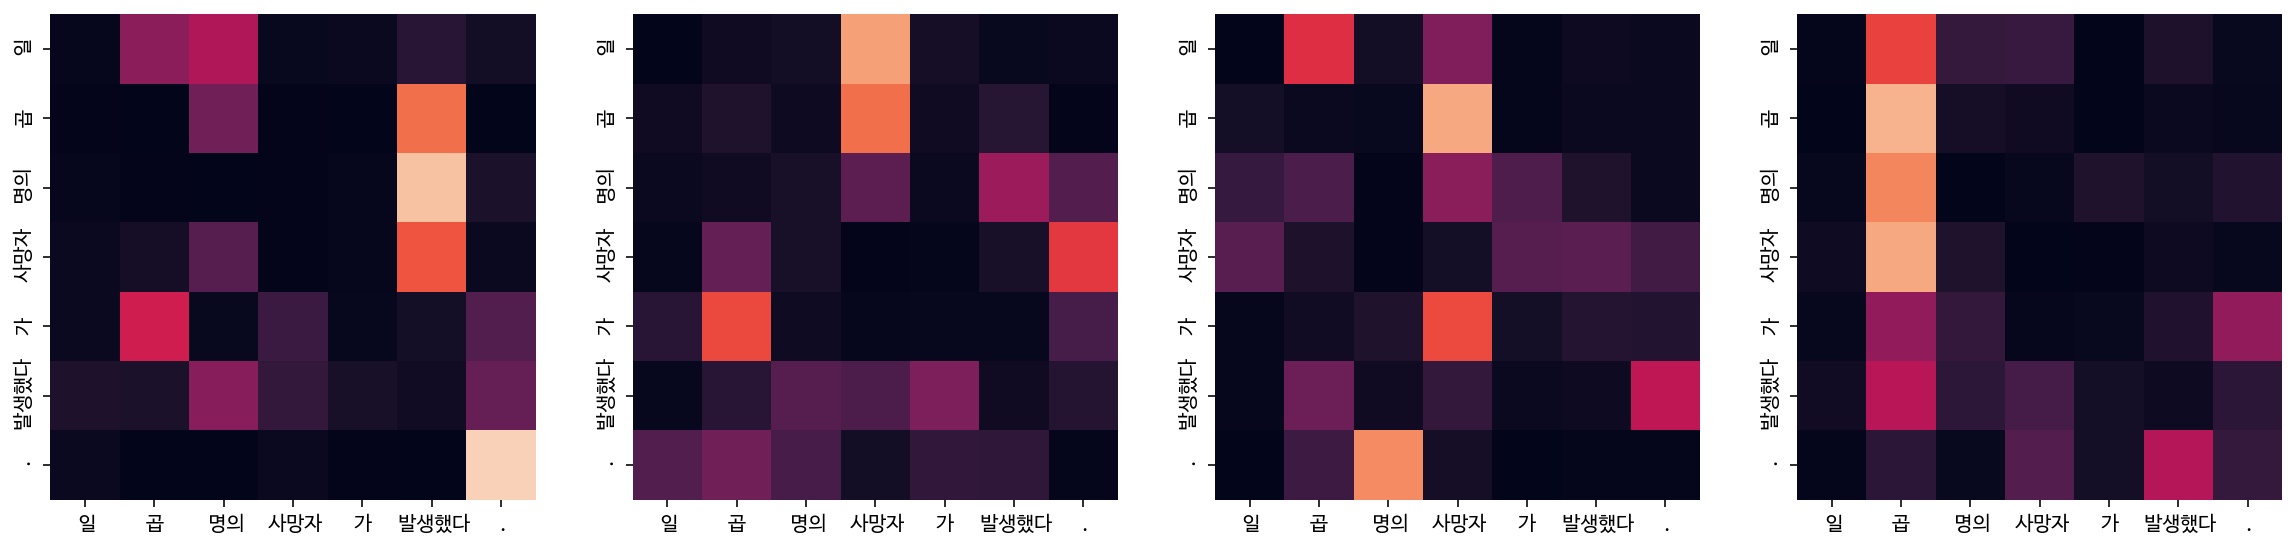

Encoder Layer 2


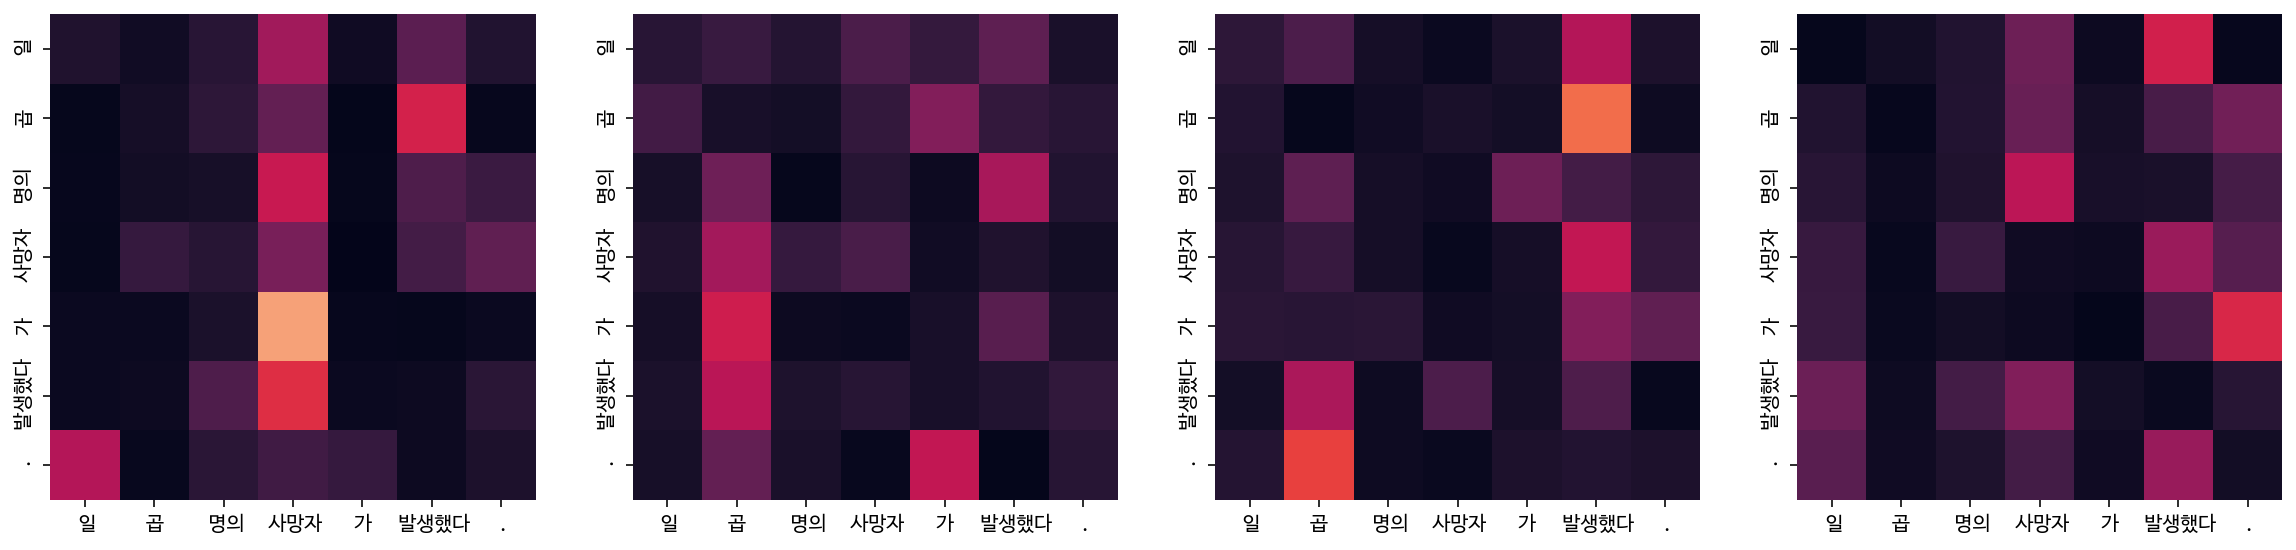

Decoder Self Layer 1


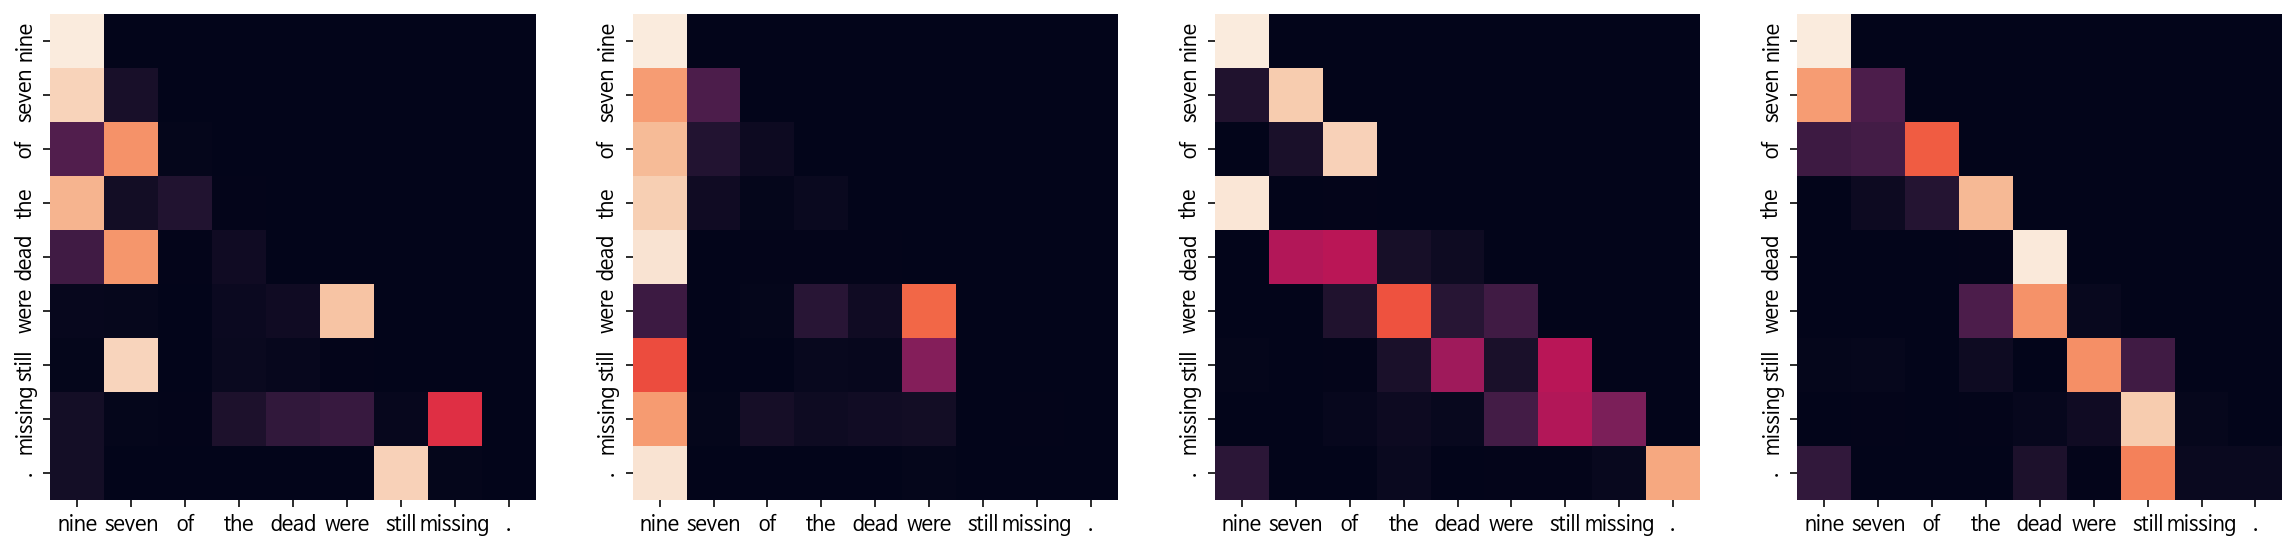

Decoder Src Layer 1


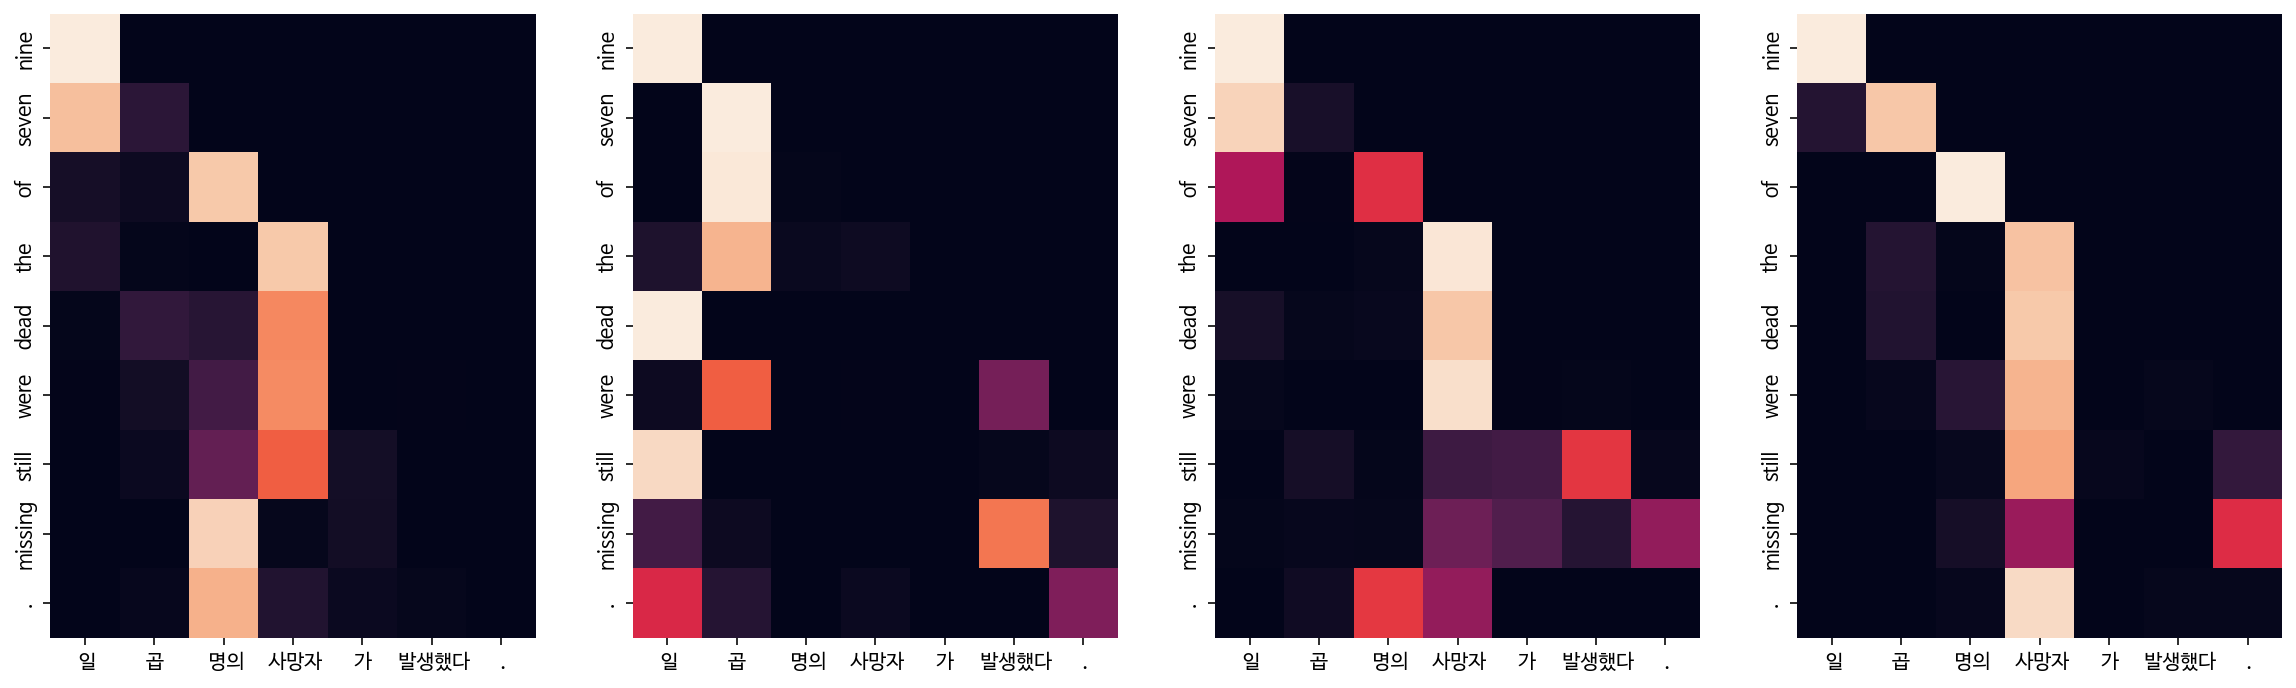

Decoder Self Layer 2


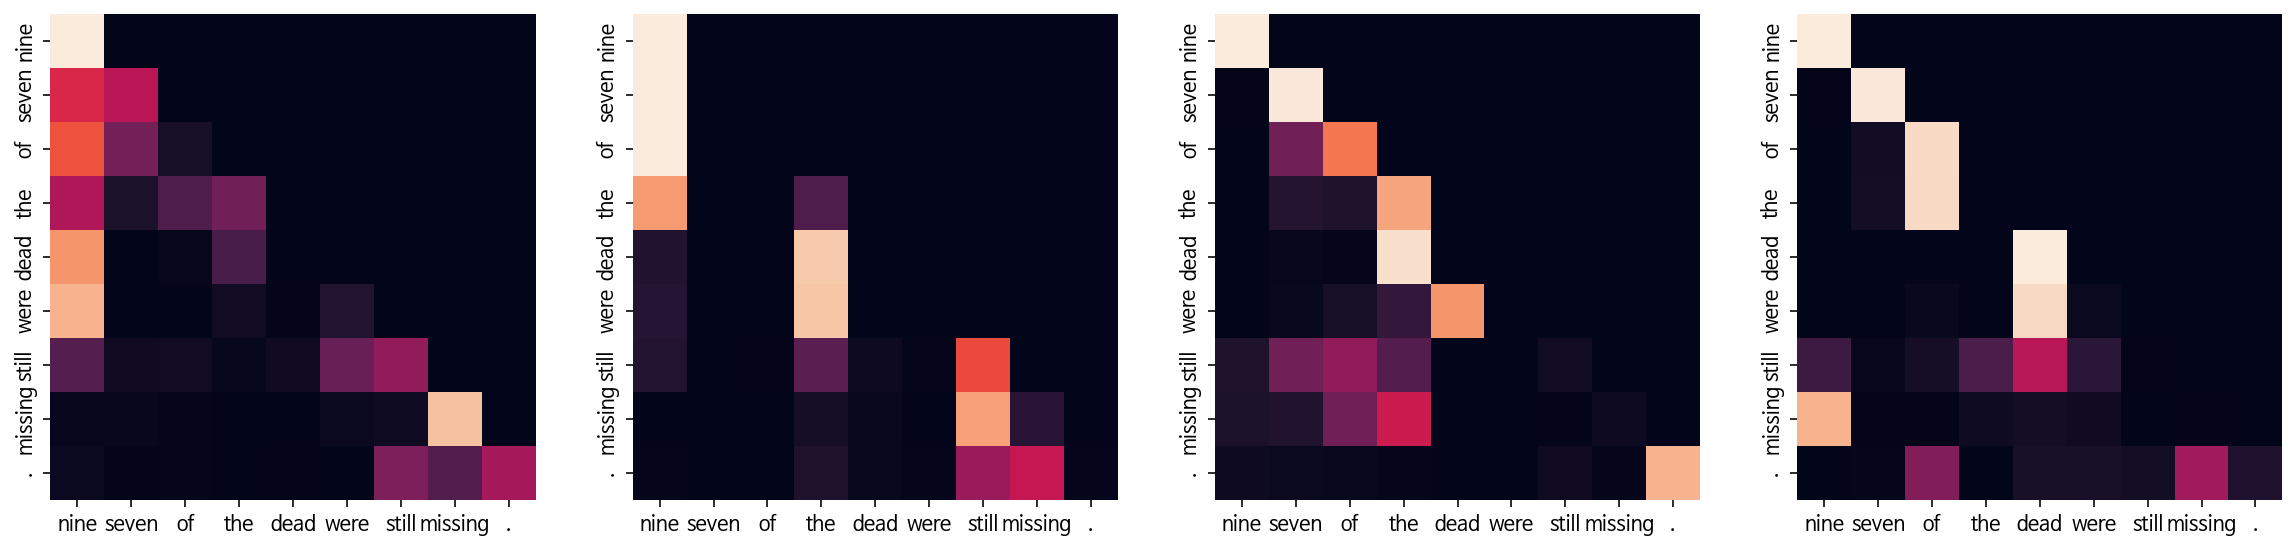

Decoder Src Layer 2


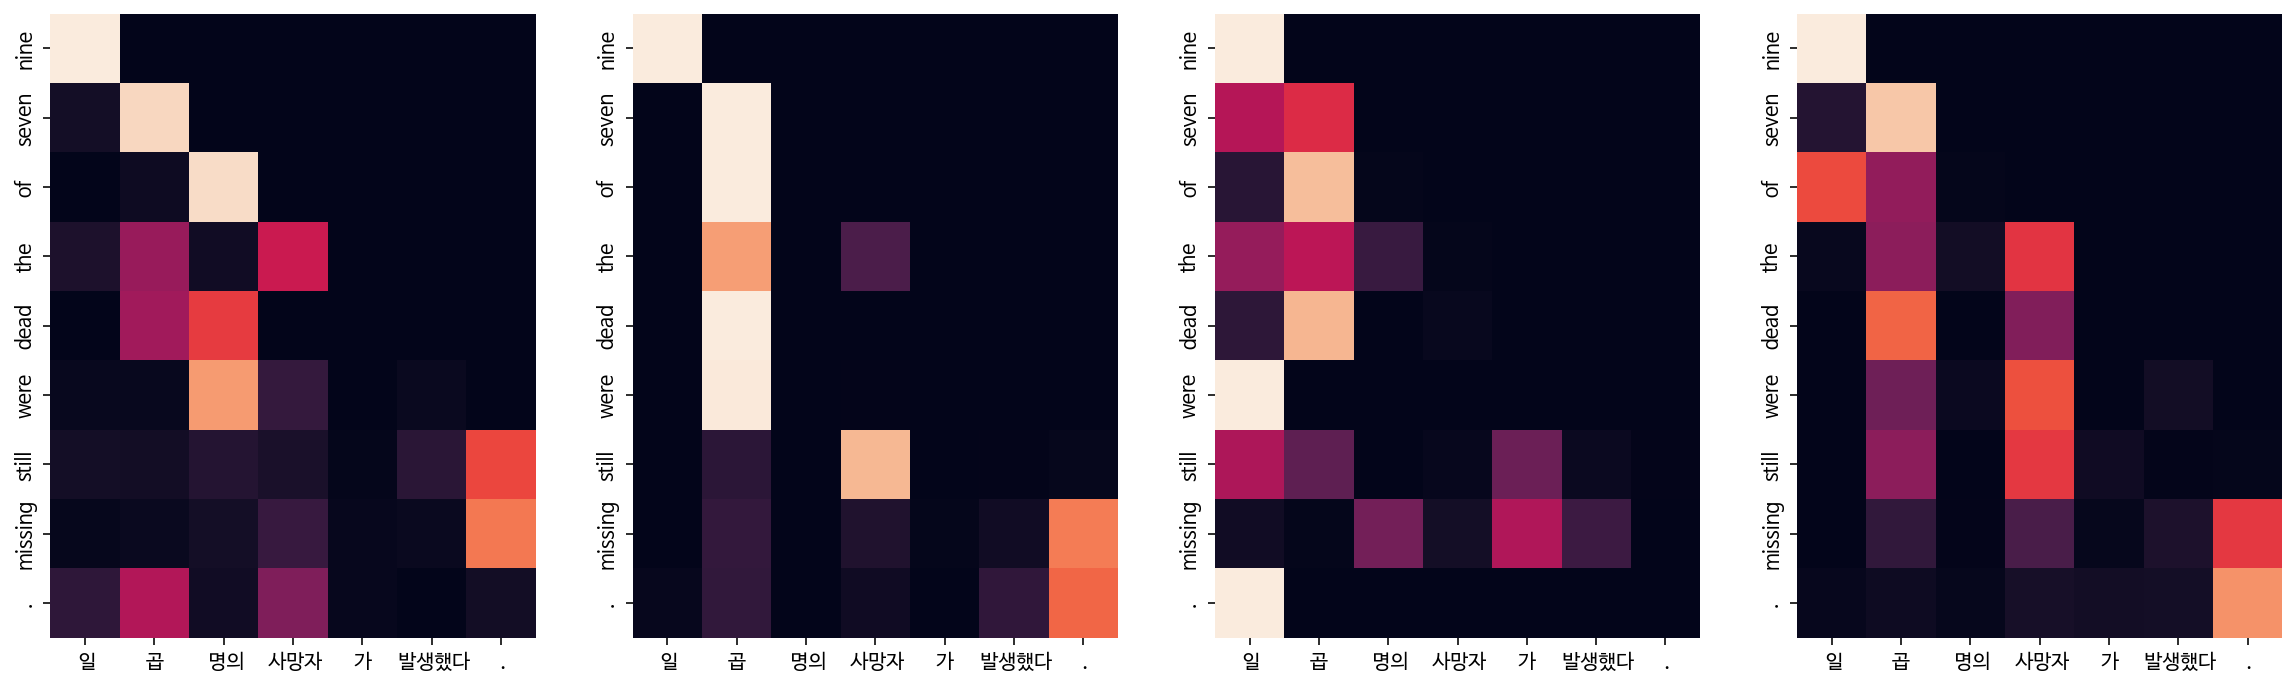

In [160]:
translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

# 테스트기록

### (1)

- Input: 오바마는 대통령이다.
- Predicted translation: obama is the president .
- Input: 시민들은 도시 속에 산다.
- Predicted translation: the city s most important
- Input: 커피는 필요 없다.
- Predicted translation: the people are being .
- Input: 일곱 명의 사망자가 발생했다.
- Predicted translation: the u . s . house was in .

첫번째 문장은 잘 해석했으나 나머지 문장의 해석이 부족함
- 테스트 문장의 개수 20000 -> 50000 로 증강 후 재학습

### (2)

Input: 오바마는 대통령이다.

Predicted translation: obama is the nominee of the country .

Input: 시민들은 도시 속에 산다.

Predicted translation: they d put the city streets .

Input: 커피는 필요 없다.

Predicted translation: not everyone cannot give you anything to do .

Input: 일곱 명의 사망자가 발생했다.

Predicted translation: nine people have died sunday after seven days .

- 문장 증강후 표현력이 늘었음
- 7epoch 이후로 loss는 줄었지만, 문장의 완성도는 줄어듬

### 후기

배운점
- attention 모델에 대해서 직관적으로 이해할 수 있었다.
- SeqtoSeq 모델의 성능보다 transformer 모델의 성능이 비약적으로 좋을 것을 체감했다

아쉬운점
- 여전히 학습속도가 느려서 다양한 하이퍼파라미터에 대한 test를 진행하지 못해서 아쉬웠다

느낀점
- 수학적으로는 이해하기 어려웠는데 코드로 접근하니까 이해할 수 있었던 부분이 많았다.
- 아직 수식이나 코드적으로 추가적인 이해가 필요하다고 생각했다.

어려웠던점
- loss는 떨어지지만 채팅성능이 좋아지기도 하고 않좋아지기도 하였는데 어느 타이밍이 가장 좋은 성능을 내는지 판단하기 어려웠다.